# 2 Classification of snoRNAs with Convolutional Neural Networks (CNN) with the Primary Sequence

## The Basic CNN architecture for our first predictions

We want to use the package keras from Tensorflow for our classification. 

Keras provides a very simple type of model class, the [Sequential Model](https://keras.io/api/models/sequential/). To create a classification model, you simply have to create an instance of the sequential class

Then, you can add the desired layers using the `.add()` method.

### Our basic architecture

The basic classifier we want to use has the following architecture:

One `Conv1D()` layer ([Doc](https://keras.io/api/layers/convolution_layers/convolution1d/)). This performs the convolutions for use. We will use 32 filters (sometimes called kernels) of size 7 (scanning the sequence in windows of 7 nucelotides). The activation function will be [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), and we will perform ["zero-padding"](https://deepai.org/machine-learning-glossary-and-terms/padding) ("same"; evenly adding zeros to the left and right if we have in the size of seven not 7 nucelotides). Lastly, we need to specify the input dimensions. In our dataset we define the input as (660, 1) meaning a size of 600 (representing the amount of nucleotides) for each sequence and one dimension.

Next is the [Max Pooling](https://keras.io/api/layers/pooling_layers/max_pooling1d/) step, with a poolsize of 4.

After that, we will add a [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) layer. Dropout randomly removes a specified fraction of the neural connections (in our case 50%) to avoid overfitting. Dropout is one of many methods of [Regularization](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a), which aim to stop the method from simply memorizing the training data and thus struggling with test data.

Next is the [flattening](https://keras.io/api/layers/reshaping_layers/flatten/) step to combine the 32 filters into one again.

Lastly, we will output the label using a [Dense](https://keras.io/api/layers/core_layers/dense/) layer. This layer has to have one node for each label. We will use the [Softmax](https://en.wikipedia.org/wiki/Softmax_function) function, which outputs probabilities for each label between 0 and 1. 

Our model will train using the [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) optimizer, our loss will be determined through [Categorical Crossentropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

In [1]:
from tensorflow import keras

def create_cnn_model_1():
    
    # create the model
    model = keras.Sequential()

    # Add a convolutional layer
    model.add(keras.layers.Conv1D(32, 7, activation='relu', padding='same', input_shape=(600, 1)))
    
    # Pool the sequences to the maximum value
    model.add(keras.layers.MaxPooling1D(4))
    
    # Add Dropout to avoid overfitting
    model.add(keras.layers.Dropout(rate = 0.5))
    
    # "Flatten" the output (combining all the values from the previous layer into a vector)
    model.add(keras.layers.Flatten())

    # Output the prediction
    model.add(keras.layers.Dense(3, activation="softmax")) 

    # Create the optimizer that will do the learning for us
    Adam = keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile the model and set the loss function
    model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

## Reading and pre-process the sequences as input file for the CNN

First we need to read in the data set and perform some pre-processing steps.

In [2]:
import pandas as pd

full_df = pd.read_csv("full_df.csv", index_col=0)


### Preprocessing

We cannot simply input the sequences directly like images but have to first define a common size in our case length of all the sequences. As sequences are not of the same length we have to artificially increase the shorter sequences to a common length or remove nucleotides until we have a minimal common length which would reduce the amount of information. In our example here we know that no seqeunce is longer than 600 nucleotides (nt). For this reason we choose 600 as our common length.

### Padding the sequences

The input of convolutional neural networks has to be a fixed length, but our sequences have very heterogene lengths. We will fix this, by "padding" the sequences to a length of 600 nucleotides using a filler character. THis padding is different from the padding command of the CNN [Conv1D] layer. The "padding" here is in the beginning to make the input equal and the padding in the convolutional layer is coping with uneven filter sizes during the window shifting.

The Python methods `.rjust()` and `.ljust()` take our nucleotide sequence as string and append a character to the left of it (`rjust`) until a specific length is reached and vice versa for `ljust`.  

We will create a new column in our dataframe that pads the sequences on the left using `full_df.sequence.str.rjust(600, "_")`. This will append the "_" character on the left of the sequence until the sequence is 600 nt long. You can use any character you like with the restriction not to choose any from your alphabet in the sequences. Note, that you will have to put `.str.` between the column and rjust, because rjust will not work on a series. `.str.` treats the entries of the series individually. You can read more about rjust and ljust [here](https://www.tutorialsteacher.com/python/string-rjust). We will start by padding our sequences on the left using `rjust()`.

In [3]:
full_df["seq_pad_left"] = full_df["sequence"].str.rjust(600, "_")

What do the sequences look like now?

In [4]:
print(full_df["seq_pad_left"][0])
print(f"\nSequence length: {len(full_df['seq_pad_left'][0])}")

_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________GCATGGCAATGGATTTATGGTGGGGTCTGCCACATGACCCTTCCATAGTGTACCCCATGCTATATTATACGTGCTACTCCGAACCATTGTCTGGCCTTCCTCTGTAGGCTTTGTTCACTGAAGTGAGTAGGACATCC

Sequence length: 600


But after the "padding" we now have 600 nucleotides and a character of your choice. But Keras models require the input to be as numerical values or tuples of numerical values so we have to process our sequences from strings of characters to integers or floats or tuples of integers or floats. 

We will have to transform our sequences into lists of numbers. Python provides the `ord()` [function](https://www.w3schools.com/python/ref_func_ord.asp), which encodes characters into their ASCII value. So by this we can encode the sequence characters as numerical values.

In [5]:
full_df["ord_encoded_left"] = full_df["seq_pad_left"].map(lambda x: [ord(char) for char in x])

This will look confusing at first, but I will try to break it down into smaller pieces:

`full_df["seq_pad_left"]` takes the desired column

`.map()` applies a function to every entry in the column to create a new list

`lambda x: ` is a neat python trick to create temporary functions. Basically, you tell python, that you want to everything after the ":" done to x. You can read more on lambda functions [here](https://www.w3schools.com/python/python_lambda.asp)

`[ord(char) for char in x]` is what we want to do to "x". The brackets `[ ... ]` tell python, that you want to create a new list. `ord(char) for char in x` means, that we want to iterate through every character in our string x and transform it into its ordinal encoding. `char` in this case is just a variable name. You can read more on list comprehension [here](https://www.w3schools.com/python/python_lists_comprehension.asp)

So, what we end up with is a new column, which for each sequence will have a list of integers (numbers) corresponding to the encoding of the nucleotides.


In [6]:
print(full_df["ord_encoded_left"][0])

[95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,

`ord()` encoded "A" as 65, "C" as 67, "G" as 71 and "T" as 84. The padding character "\_" is encoded as 95

## Preparing our datasets to perform the first model training

Just like with the Naive Bayes classifiers, we need to split the data into train and test. If you want to use the same split from the first notebook, make sure you set the random state to the same number as before. 

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(full_df[["ord_encoded_left"]], full_df["type"], test_size=0.15, random_state=1896, stratify=full_df["type"])



Our numerically encoded sequences will need to be transformed into a numpy array as well, otherwise Keras will not be able to use them. Do that using the following command.

In [8]:
import numpy as np

# Transform the training input into an array and reshape it so it fits the model
X_train_array_left = np.array(X_train["ord_encoded_left"].to_list()).reshape(4878, 600, -1)

This will look confusing at first. This is because we are handling different data types that need intermediate steps to be transformed into each other. Let's break it down in the order of operations:

`X_train["ord_encoded_left"]` accesses the desired column we want for our model input. This column is of the type "series", whose entries are lists of integers.

`.to_list()` turns the series into a list. A series and a list are essentially the same, but internally they are handled slightly differently. We need this intermediate step because...

`np.array()` takes a list of lists and transforms them into a matrix (an array). This is almost ready for our machine learning model, we only need to 

`.reshape(4878, 600, -1)` the data. This is because Keras expects the data to be of a certain shape. 4878 is the number of samples in the training set, 600 is the length of each row. 

We need to do the same for the test data

In [9]:
X_test_array_left = np.array(X_test["ord_encoded_left"].to_list()).reshape(861, 600, -1)

We are almost ready to perform our first CNN classification. The only thing left to do, is encoding the output using [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). Since our model outputs a probability distribution between 0 and 1 from the softmax function, we need to encode each class as a tuple of values like `[1, 0, 0]` (100% C/D-Box). The one-hot encoder will encode C/D-Box as `[1, 0, 0]`, H/ACA-Box as `[0, 1, 0]` and scaRNA as `[0, 0, 1]`. If the model outputs `[0.60, 0.25, 0.15]` this will mean the model thinks the sequence is 60% C/D-Box, 25% H/ACA-Box, 15% scaRNA.

Note, that for fitting and transforming the list of labels, you will need to turn them into a numpy array using `np.array()` and reshape them using `.reshape(-1, 1)`

In [10]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)  # Create an instance of the OneHotEncoder class. 
# sparse=True would be useful for instances with a lot of different labels, but for this case we don't need it

ohe.fit(np.array(Y_train).reshape(-1, 1))  # Fit the encoder to our data

Y_train_ohe = ohe.transform(np.array(Y_train).reshape(-1, 1))  # Transform the training labels

Y_test_ohe = ohe.transform(np.array(Y_test).reshape(-1, 1))  # Transform the test labels

## Train the CNN model

Now we are finally ready to train our first CNN classifier. We will train the model for 20 epochs with a [batch size](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) of 40. So every 40 sequences the model will get an update of the internal parameter. `verbose` indicates, how much information will be output during training (If you want a progress bar for each epoch, you can set it to 1). The `validation_split` is the fraction of training data, that is reserved for validation during training. After each epoch, the model is tested on the validation data, such that you know how well the model performs on unseen data. Note, that this is not the test set, which will come into play later. You can read about the difference between test and validation data [here](https://machinelearningmastery.com/difference-test-validation-datasets/). 

In [11]:
# Create an instance of the above model
model = create_cnn_model_1()

# Fitting the model with the train data. You can also save the history to look at the training in more detail
history_left = model.fit(X_train_array_left, Y_train_ohe, epochs=20, batch_size=40, verbose=2, validation_split=0.15)

Epoch 1/20
104/104 - 2s - loss: 12.0638 - accuracy: 0.3989 - val_loss: 0.8021 - val_accuracy: 0.6680 - 2s/epoch - 21ms/step
Epoch 2/20
104/104 - 1s - loss: 0.8388 - accuracy: 0.6317 - val_loss: 0.6296 - val_accuracy: 0.7404 - 1s/epoch - 14ms/step
Epoch 3/20
104/104 - 1s - loss: 0.6986 - accuracy: 0.6987 - val_loss: 0.5750 - val_accuracy: 0.7937 - 1s/epoch - 14ms/step
Epoch 4/20
104/104 - 1s - loss: 0.6439 - accuracy: 0.7241 - val_loss: 0.5373 - val_accuracy: 0.8005 - 1s/epoch - 14ms/step
Epoch 5/20
104/104 - 1s - loss: 0.6071 - accuracy: 0.7424 - val_loss: 0.5330 - val_accuracy: 0.7992 - 1s/epoch - 13ms/step
Epoch 6/20
104/104 - 1s - loss: 0.5980 - accuracy: 0.7547 - val_loss: 0.5148 - val_accuracy: 0.8033 - 1s/epoch - 14ms/step
Epoch 7/20
104/104 - 1s - loss: 0.5710 - accuracy: 0.7653 - val_loss: 0.5018 - val_accuracy: 0.8101 - 1s/epoch - 13ms/step
Epoch 8/20
104/104 - 1s - loss: 0.5742 - accuracy: 0.7636 - val_loss: 0.5002 - val_accuracy: 0.8019 - 1s/epoch - 14ms/step
Epoch 9/20
104/

You should now have an output for each epoch that looks roughly like this: 

`Epoch 9/10`

`104/104 - 1s - loss: 0.3776 - accuracy: 0.8570 - val_loss: 0.4293 - val_accuracy: 0.8429 - 633ms/epoch - 6ms/step`

`104/104` is the progress. Essentially, this iterates through every training batch.

`1s` is the time passed for each epoch. This will increase with model complexity.

`loss: ` is the training [loss](https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/), essentially, how far off are the predictions on average?

`accuracy: ` is the training accuracy. How good is the prediction on the training set.

`val_loss` and `val_accuracy` are the same, but on the validation data. These are the measures we want to look at, since they indicate how well our model can predict unseen data. 

Usually, you would want to train until you are satisfied with the val_loss and val_accuracy. Due to time constraints we will limit training to 20 epochs for now. At some point, all models will plateau and it will no longer learn any meaningful information from the training data. 

We now have our first trained model with internal validation but now need an unseen dataset to verify our learning progress. Therefore we will use our testing data, we excluded so far. 

We can now use `.predict()` for the trained model to find on our new dataset the predicted ncRNA class for each sequence.

In [12]:
prediction_left = model.predict(X_test_array_left)

27/27 [==============================] - 0s 1ms/step


Let's look at our prediction:

In [13]:
print(prediction_left)

[[0.9495999  0.01240289 0.03799718]
 [0.9614531  0.01133152 0.02721548]
 [0.97956616 0.00822593 0.01220787]
 ...
 [0.05248537 0.17102666 0.776488  ]
 [0.0034072  0.11675233 0.87984043]
 [0.05017988 0.16931465 0.7805055 ]]


The model outputs  at stage the encoded probabilities for each class. If we want to look at the classification report, we will have to turn the prediction back into the labels.

Luckily, our OneHotEncoder has a method for inverse transformation, that will turn our probabilities into the label.

Use `.inverse_transform()` and then look at the classification report. We will also save some of the variables in the classification report, such that we can plot them later.

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Transform predictions back into labels
pred_labels_left = ohe.inverse_transform(prediction_left)

# Output the classification report
print(classification_report(Y_test, pred_labels_left))  

# Save the scores for plotting later
f1_left = f1_score(Y_test, pred_labels_left, average="weighted")
prec_left = precision_score(Y_test, pred_labels_left, average="weighted")
rec_left = recall_score(Y_test, pred_labels_left, average="weighted")

              precision    recall  f1-score   support

      CD-Box       0.87      0.94      0.90       287
    HACA-Box       0.89      0.62      0.73       287
      scaRNA       0.73      0.89      0.80       287

    accuracy                           0.82       861
   macro avg       0.83      0.82      0.81       861
weighted avg       0.83      0.82      0.81       861



**Now you can compare the classification results to our naive Bayes. Do you observe any improvement in the prediction accuracy?**

We should also investigate the influence of the side of the padding and character selection on our prediction of the CNN. So please repeat the steps, but this time use a different character for the left padding. Feel free to use any character you like (with the exception of A, C, G and T). We will compare them later in the group.


In [15]:
# Pad and ordinal encode the sequences
full_df["seq_pad_left_alt"] = full_df.sequence.str.rjust(600, "B")  # insert a different character in "" here
full_df["ord_encoded_left_alt"] = full_df.seq_pad_left_alt.map(lambda x: [ord(char) for char in x])

# Split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(full_df[["ord_encoded_left_alt"]], full_df["type"], test_size=0.15, random_state=1896, stratify=full_df["type"])  # Don't forget to set the same random state as before

# Transform Test and Train input to arrays
X_train_array_left_alt = np.array(X_train.ord_encoded_left_alt.to_list()).reshape(4878, 600, -1)
X_test_array_left_alt = np.array(X_test.ord_encoded_left_alt.to_list()).reshape(861, 600, -1)

Create the model and test it

In [16]:
# Create and fit the model
model = create_cnn_model_1()
history_left_alt = model.fit(X_train_array_left_alt, Y_train_ohe, epochs=20, batch_size=40, verbose=2, validation_split=0.15)  # Enter the missing parameters from above

Epoch 1/20
104/104 - 2s - loss: 8.2274 - accuracy: 0.4221 - val_loss: 0.7271 - val_accuracy: 0.7117 - 2s/epoch - 16ms/step
Epoch 2/20
104/104 - 1s - loss: 0.7947 - accuracy: 0.6628 - val_loss: 0.5674 - val_accuracy: 0.7801 - 1s/epoch - 14ms/step
Epoch 3/20
104/104 - 1s - loss: 0.6651 - accuracy: 0.7236 - val_loss: 0.5407 - val_accuracy: 0.8033 - 1s/epoch - 14ms/step
Epoch 4/20
104/104 - 1s - loss: 0.6239 - accuracy: 0.7479 - val_loss: 0.5219 - val_accuracy: 0.8251 - 1s/epoch - 13ms/step
Epoch 5/20
104/104 - 1s - loss: 0.6141 - accuracy: 0.7523 - val_loss: 0.5290 - val_accuracy: 0.7896 - 1s/epoch - 14ms/step
Epoch 6/20
104/104 - 1s - loss: 0.5878 - accuracy: 0.7660 - val_loss: 0.5051 - val_accuracy: 0.7992 - 1s/epoch - 14ms/step
Epoch 7/20
104/104 - 1s - loss: 0.5897 - accuracy: 0.7711 - val_loss: 0.4958 - val_accuracy: 0.8101 - 1s/epoch - 13ms/step
Epoch 8/20
104/104 - 1s - loss: 0.5754 - accuracy: 0.7709 - val_loss: 0.4862 - val_accuracy: 0.8279 - 1s/epoch - 13ms/step
Epoch 9/20
104/1

Let's test the model and look at the classification report

In [17]:
prediction_left_alt = model.predict(X_test_array_left_alt)  # Predict the test set like above using the new model
pred_labels_left_alt = ohe.inverse_transform(prediction_left_alt)  # Transform the predictions back into the labels 

print(classification_report(Y_test, pred_labels_left_alt))  # Output the classification report with the true labels and the predicted labels

# Save scores for plotting
f1_left_alt = f1_score(Y_test, pred_labels_left_alt, average="weighted")
prec_left_alt = precision_score(Y_test, pred_labels_left_alt, average="weighted")
rec_left_alt = recall_score(Y_test, pred_labels_left_alt, average="weighted")

27/27 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      CD-Box       0.84      0.93      0.88       287
    HACA-Box       0.83      0.72      0.77       287
      scaRNA       0.79      0.81      0.80       287

    accuracy                           0.82       861
   macro avg       0.82      0.82      0.82       861
weighted avg       0.82      0.82      0.82       861




So far we have padded the sequences solely on the left. 

Now also pad the sequence on the right using the `.ljust()` method. 


In [18]:
# Pad the sequences and ordinal encode them
full_df["seq_pad_right"] = full_df["sequence"].str.ljust(600, "_")  # Use one of the characters we used before and enter the sequence column
full_df["ord_encoded_right"] = full_df["seq_pad_right"].map(lambda x: [ord(char) for char in x])  # Enter the colemn we need to encode
 
# Make sure you set the random state to the same number as before and choose the correct column for splitting. Stratify by the target variable
X_train, X_test, Y_train, Y_test = train_test_split(full_df[["ord_encoded_right"]], full_df["type"], test_size=0.15, random_state=1896, stratify=full_df["type"])

# Transform Test and Train input into an array
X_train_array_right = np.array(X_train["ord_encoded_right"].to_list()).reshape(4878, 600, -1) 
X_test_array_right = np.array(X_test["ord_encoded_right"].to_list()).reshape(861, 600, -1)  # Enter the column we want to transform to the array

In [19]:
model = create_cnn_model_1()
model.fit(X_train_array_right, Y_train_ohe, epochs=20, batch_size=40, verbose=2, validation_split=0.15)

# Predict the test set and transform the prediction back into labels
prediction_right = model.predict(X_test_array_right)  # Predict the padding on the right side
pred_labels_right = ohe.inverse_transform(prediction_right)  # Transform our prediction back into the labels

# Print classification report
print(classification_report(Y_test, pred_labels_right))  # Enter the true labels and our predicted labels

# Save scores for plotting later
f1_right = f1_score(Y_test, pred_labels_right, average="weighted")
prec_right = precision_score(Y_test, pred_labels_right, average="weighted")
rec_right = recall_score(Y_test, pred_labels_right, average="weighted")

Epoch 1/20
104/104 - 2s - loss: 4.2581 - accuracy: 0.5027 - val_loss: 0.6730 - val_accuracy: 0.7063 - 2s/epoch - 16ms/step
Epoch 2/20
104/104 - 1s - loss: 0.6927 - accuracy: 0.6995 - val_loss: 0.5893 - val_accuracy: 0.7418 - 1s/epoch - 14ms/step
Epoch 3/20
104/104 - 1s - loss: 0.6413 - accuracy: 0.7279 - val_loss: 0.5629 - val_accuracy: 0.7801 - 1s/epoch - 13ms/step
Epoch 4/20
104/104 - 1s - loss: 0.6039 - accuracy: 0.7451 - val_loss: 0.5345 - val_accuracy: 0.7923 - 1s/epoch - 14ms/step
Epoch 5/20
104/104 - 1s - loss: 0.5850 - accuracy: 0.7554 - val_loss: 0.5139 - val_accuracy: 0.8128 - 1s/epoch - 13ms/step
Epoch 6/20
104/104 - 1s - loss: 0.5639 - accuracy: 0.7634 - val_loss: 0.5093 - val_accuracy: 0.7992 - 1s/epoch - 14ms/step
Epoch 7/20
104/104 - 1s - loss: 0.5448 - accuracy: 0.7783 - val_loss: 0.5361 - val_accuracy: 0.7842 - 1s/epoch - 14ms/step
Epoch 8/20
104/104 - 1s - loss: 0.5568 - accuracy: 0.7656 - val_loss: 0.5028 - val_accuracy: 0.8142 - 1s/epoch - 13ms/step
Epoch 9/20
104/1

**How big is the influence of the padding side and character selection for or training? Can you imagine possible interpretations.**

**Is the difference in the range of retraining the models?**

As the nature of neural networks is non-deterministic (weights are randomly initialized) two models with the same configuration don't have to be exactly the same. Also the differences might also come from variances among the training/validation split.

## Cross-Validation

We want to embrace the randomness by splitting our training set into 5 equal parts, each of which will be the validation set one time and the training set the other times. This procedure is called (3-fold) [Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). You create each model 3 times, then test it on the test set and average over the results. Normally, you would even want to do this at least 10 times for the k-fold cross validation or perform a leave one out ([LOO](https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/)) approach.

For our example we will use scikit-learn's [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to create three folds. 

For each fold we want to save the history of training, and the test scores. We will do this using dictionaries, where the keys are the encoding ("left", "left_alt" and "right") and the values are lists. You will be able to access history of the 2nd fold of the left padding model with `history_dict["left"][1]`.

You will not need to fill in any blank spaces in this block, but try to go through every line and understand what it does.

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

kfold = StratifiedKFold()

# We will use a dictionary to save our histories 
history_dict = {"left": [], "left_alt": [], "right": []}

# We will use a dictionary to save the scores
f1_dict = {"left": [], "left_alt": [], "right": []}

# We will use dictionary to save the predictions
pred_dict = {"left": [], "left_alt": [], "right": []}

# Since the arrays were all created from the same train set, we can simply use the same splits for all three training sets
# We will run another variable called i that is the number of the fold
for i, (train_index, val_index) in zip(range(3), kfold.split(X_train_array_right, Y_train)):  
    
    print(f"\n\nNow creating fold {i+1}\n\n")  # +1 since python starts counting at 0
    
    print(f"Running the left model")
    model_left = create_cnn_model_1() 
    # Fit the model and save it in the history dict
    history_dict["left"].append(model_left.fit(X_train_array_left[train_index], Y_train_ohe[train_index],
                   epochs=20, batch_size=40, verbose=0,
                   validation_data=(X_train_array_left[val_index], Y_train_ohe[val_index]))) 
    
    # Predict the test data
    prediction_left = model_left.predict(X_test_array_left)
    # Inverse transform
    pred_left_labels = ohe.inverse_transform(prediction_left)
    # Save the prediction
    pred_dict["left"].append(pred_left_labels)
    # Save the F1 score
    f1_dict["left"].append(f1_score(Y_test, pred_left_labels, average="weighted"))
    
    # The same for the alternative encoding
    print(f"Running the left_alt model")
    model_left_alt = create_cnn_model_1()
    history_dict["left_alt"].append(model_left_alt.fit(X_train_array_left_alt[train_index], Y_train_ohe[train_index],
                   epochs=20, batch_size=40, verbose=0,
                   validation_data=(X_train_array_left_alt[val_index], Y_train_ohe[val_index])))
    prediction_left_alt = model_left.predict(X_test_array_left_alt)
    pred_left_alt_labels = ohe.inverse_transform(prediction_left_alt)
    pred_dict["left_alt"].append(pred_left_alt_labels)
    f1_dict["left_alt"].append(f1_score(Y_test, pred_left_alt_labels, average="weighted"))
    
    # The same for the right model
    print(f"Running the right model")
    model_right = create_cnn_model_1()
    history_dict["right"].append(model_right.fit(X_train_array_right[train_index], Y_train_ohe[train_index],
                   epochs=20, batch_size=40, verbose=0,
                   validation_data=(X_train_array_right[val_index], Y_train_ohe[val_index])))
    prediction_right = model_right.predict(X_test_array_right)
    pred_right_labels = ohe.inverse_transform(prediction_right)
    pred_dict["right"].append(pred_right_labels)
    f1_dict["right"].append(f1_score(Y_test, pred_right_labels, average="weighted"))
    




Now creating fold 1


Running the left model
27/27 [==============================] - 0s 2ms/step
Running the left_alt model
27/27 [==============================] - 0s 3ms/step
Running the right model
27/27 [==============================] - 0s 826us/step


Now creating fold 2


Running the left model
27/27 [==============================] - 0s 2ms/step
Running the left_alt model
27/27 [==============================] - 0s 3ms/step
Running the right model
27/27 [==============================] - 0s 2ms/step


Now creating fold 3


Running the left model
27/27 [==============================] - 0s 822us/step
Running the left_alt model
27/27 [==============================] - 0s 3ms/step
Running the right model
27/27 [==============================] - 0s 2ms/step


With the information gathered over the different models and the average we will be able to find more robust results of our performance.

Sometimes a model may not learn any meaningful information, because it gets stuck in a local minimum right away. In this case, the mean value may be skewed, since it is succeptible to outliers. To avoid this issue, we will also check out the median values, which is robust against outliers. 

Lastly, we need to compare the single trained models to get information about the variance (in the form of a table). Transform the dictionary into a pandas Dataframe using `.from_dict()`. Does one epoch perform better than the others for all three models? What might be the reason for this?

In [21]:
import numpy as np  # useful for printing mean and median scores

# Print the mean F1-scores for each model
print(f"The mean F1-score for the left model is {np.mean(f1_dict['left'])}")
print(f"The mean F1-score for the left_alt model is {np.mean(f1_dict['left_alt'])}")  # Enter the model key to the dictionary
print(f"The mean F1-score for the right model is {np.mean(f1_dict['right'])}\n\n")  # Perform the same for the right model

# Print the median F1-score for each model
print(f"The median F1-score for the left model is {np.median(f1_dict['left'])}")
print(f"The median F1-score for the left_alt model is {np.median(f1_dict['left_alt'])}")  # Print the median for the alt encoding
print(f"The median F1-score for the right model is {np.median(f1_dict['right'])}\n\n")  # Print the median for the right model

# Print the scores in the form of a table
print(pd.DataFrame.from_dict(f1_dict))

The mean F1-score for the left model is 0.8178301167977308
The mean F1-score for the left_alt model is 0.8039421770808617
The mean F1-score for the right model is 0.8063695180544871


The median F1-score for the left model is 0.817177179076411
The median F1-score for the left_alt model is 0.802343045326563
The median F1-score for the right model is 0.8097692840577091


       left  left_alt     right
0  0.794643  0.781923  0.798030
1  0.817177  0.802343  0.809769
2  0.841670  0.827561  0.811309


This values can be also visualized using seaborn to create a boxplot. 

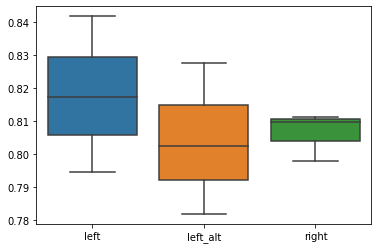

In [22]:
import seaborn as sns

plot = sns.boxplot(data=pd.DataFrame.from_dict(f1_dict))

**We can now identify the influence of padding as well as the selection of the character as placeholder**

In contrast to our first classifier a neural network as well as CNNs are training over so called epochs. This means we should also track the val_loss and val_accuracy over time (epochs). So we can identify if the model is stucking from time to time in local optima or is constantly learning.

Therefore we plot the loss and accuracy of the best model throughout every epoch. You can also compare if the padding "left", "right", "left_alt" showes differences in their learning over time.

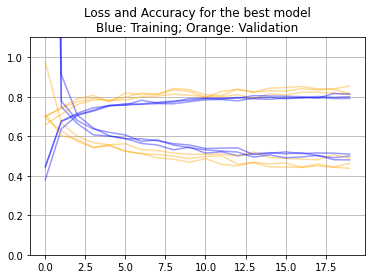

In [23]:
import matplotlib.pyplot as plt

ax = plt.subplot()

# Iterate over every fold
for i in range(3):
    # Plot Validation scores
    # Feel free to change the "left" column to the best scoring model
    ax.plot(history_dict["left"][i].history['val_accuracy'], label=f'val acc {i}', color="orange", alpha=0.4)
    # Put in the same column as above
    ax.plot(history_dict["left"][i].history['val_loss'], label=f'val loss {i}', color="orange", alpha=0.4)  
    
    # Plot Training scores
    ax.plot(history_dict["left"][i].history['accuracy'], label=f'acc {i}', color="blue", alpha=0.4)
    ax.plot(history_dict["left"][i].history['loss'], label=f'loss {i}', color="blue", alpha=0.4)


ax.set_ylim(0,1.1)
ax.grid(True)
plt.title("Loss and Accuracy for the best model\nBlue: Training; Orange: Validation")
plt.show()

# Optimize the training of the initial CNN model 

At stage we used sequential features in Notebook 1 and now the sequence translated as integers. 

**Can we assume that the CNN is smart enough not to create a bias?**

For example: "A" is encoded as 1 and "T" is encoded as 4. Is the CNN now interpreting "T's" as for times more important as "A's"? Is this a biologically sensful approach to create an order of nucelotides like A\<C\<G\<T?

For removing such probable weighting we will now perform an encoding of the input beforehand.

## Remove Weighting of Nucleotides 

Luckily, we have already used a method for creating equally weighted numerical encoding. Remember when we encoded the output labels? We used one-hot encoding to encode "CD-Box" as `[1, 0, 0]`, "HACA-Box" as `[0, 1, 0]` and "scaRNA" as `[0, 0, 1]`. We could do the same for the nucleotides. 

Create a new `OneHotEncoder` (not sparse) but add `handle_unknown="ignore"`. If one of the other [IUPAC codes](https://droog.gs.washington.edu/parc/images/iupac.html) for nucleotides snuck into our sequences, this will make sure that they do not create a new row for each of the inputs. 

We will use `.map()` with a `lambda` function to transform the ordinal encoded sequences in the original `full_df`.

In [24]:
# Create the one hot encoder
ohe_seq_1 = OneHotEncoder(sparse=False, handle_unknown="ignore")

# Fit the one-hot encoder to the data
ohe_seq_1.fit(np.array(full_df["ord_encoded_left"][0]).reshape(-1, 1))

# Create a new column with the transformed one-hot encoded input
full_df["seq_ohe"] = full_df["ord_encoded_left"].map(lambda x: ohe_seq_1.transform(np.array(x).reshape(-1,1)))

The last expression may look a little tricky, but this is again because we are handling different datatypes and -shapes.

The encoded sequences have now the following shape:

In [25]:
print(full_df["seq_ohe"][0])

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


The encoding is `A = [1, 0, 0, 0, 0]`, `C = [0, 1, 0, 0, 0]`, `G = [0, 0, 1, 0, 0]`, `T = [0, 0, 0, 1, 0]` and `_ = [0, 0, 0, 0, 1]`.

Let's split our data into train and test again. Make sure you use the same `random_state` as before.

In [26]:
# Set the random state to the same number as before
X_train, X_test, Y_train, Y_test = train_test_split(full_df[["seq_ohe"]], full_df["type"], test_size=0.15, random_state=1896, stratify=full_df["type"])

Put the data into an array again

In [27]:
X_train_array_ohe = np.array(X_train.seq_ohe.to_list()).reshape(len(X_train), 600, 5)
X_test_array_ohe = np.array(X_test.seq_ohe.to_list()).reshape(len(X_test), 600, 5)

We will not be needing the full_df anymore after this, let's delete it to free up some RAM. We can use the Python [Garbace Collector](https://docs.python.org/3/library/gc.html) to make sure, the RAM is freed immediately. Let's also delete the old train sets

In [40]:
import gc

del full_df, X_train_array_left, X_train_array_left_alt, X_train_array_right, X_test_array_left, X_test_array_left_alt, X_test_array_right
gc.collect()

19674

The input dimensions of our data has changed slightly. Instead of `input_shape=(600, 1)`, we will now have to specify `(600, 5)`, to account for the four additional rows in each input. Other than that, we will use the same model. 

In [28]:
def create_cnn_model_2():
    
    # create the model
    model = keras.Sequential()

    # Enter the values for activation and padding like in the previous models
    model.add(keras.layers.Conv1D(32, 7, activation="relu", padding="same", input_shape=(600, 5)))
    model.add(keras.layers.MaxPooling1D(4))
    model.add(keras.layers.Dropout(rate = 0.5))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(3, activation="softmax")) 

    Adam = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


Create an instance of the new model and train it on the one-hot encoded training array. This time, let's train a little longer. Train for 40 epochs on a batch size of 40 and with a validation split of 0.15.

We want to look at the training afterwards in more detail, so lets save the training as a history object.


In [29]:
# Create and fit the model to the training data
model = create_cnn_model_2()
history = model.fit(X_train_array_ohe, Y_train_ohe, epochs=60, batch_size=40, verbose=2, validation_split=0.15) # Enter the missing parameters

Epoch 1/60
104/104 - 2s - loss: 0.7294 - accuracy: 0.6816 - val_loss: 0.5180 - val_accuracy: 0.8374 - 2s/epoch - 21ms/step
Epoch 2/60
104/104 - 2s - loss: 0.4746 - accuracy: 0.8341 - val_loss: 0.3844 - val_accuracy: 0.8675 - 2s/epoch - 18ms/step
Epoch 3/60
104/104 - 2s - loss: 0.3889 - accuracy: 0.8589 - val_loss: 0.3225 - val_accuracy: 0.8962 - 2s/epoch - 17ms/step
Epoch 4/60
104/104 - 2s - loss: 0.3324 - accuracy: 0.8845 - val_loss: 0.2908 - val_accuracy: 0.9057 - 2s/epoch - 18ms/step
Epoch 5/60
104/104 - 2s - loss: 0.3131 - accuracy: 0.8876 - val_loss: 0.2625 - val_accuracy: 0.9126 - 2s/epoch - 17ms/step
Epoch 6/60
104/104 - 2s - loss: 0.2831 - accuracy: 0.9023 - val_loss: 0.2641 - val_accuracy: 0.9221 - 2s/epoch - 18ms/step
Epoch 7/60
104/104 - 2s - loss: 0.2696 - accuracy: 0.9050 - val_loss: 0.2375 - val_accuracy: 0.9249 - 2s/epoch - 17ms/step
Epoch 8/60
104/104 - 2s - loss: 0.2588 - accuracy: 0.9047 - val_loss: 0.2353 - val_accuracy: 0.9262 - 2s/epoch - 18ms/step
Epoch 9/60
104/1

Let's look at results

In [30]:
# Predict the test set and transform into labels
prediction_ohe = model.predict(X_test_array_ohe)
pred_labels_ohe = ohe.inverse_transform(prediction_ohe)

# Print classification report
print(classification_report(Y_test, pred_labels_ohe))

# Save scores for plotting
f1_ohe = f1_score(Y_test, pred_labels_ohe, average="weighted")
prec_ohe = precision_score(Y_test, pred_labels_ohe, average="weighted")
rec_ohe = recall_score(Y_test, pred_labels_ohe, average="weighted")

27/27 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      CD-Box       0.96      0.97      0.96       287
    HACA-Box       0.93      0.95      0.94       287
      scaRNA       0.96      0.94      0.95       287

    accuracy                           0.95       861
   macro avg       0.95      0.95      0.95       861
weighted avg       0.95      0.95      0.95       861



The scores like precision, recall and the F1-score are all improved removing the weighting of the nucleotides.

Let's look at the training. We will use matplotlib.pyplot for this and visualize the history over the epochs.

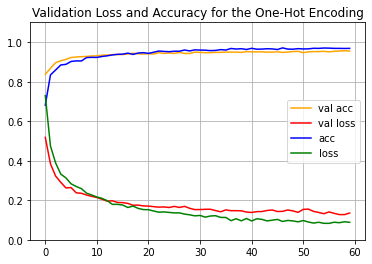

In [31]:
import matplotlib.pyplot as plt

ax = plt.subplot()

# Plot validation accuracy and loss
ax.plot(history.history['val_accuracy'], label=f'val acc', color="orange", alpha=1)
ax.plot(history.history['val_loss'], label=f'val loss', color="red", alpha=1)

# Plot training accuracy and loss
ax.plot(history.history['accuracy'], label=f'acc', color="blue", alpha=1)
ax.plot(history.history['loss'], label=f'loss', color="green", alpha=1)


ax.set_ylim(0,1.1)
ax.grid(True)
plt.legend()
plt.title("Validation Loss and Accuracy for the One-Hot Encoding")
plt.show()

**Changing the length of the training has an influence on the accuracy of our model. To create the optimal model we would like to stop automatically if the model is not further improving for some time.**

This approach is called early stopping. Keras provides a class called [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) that you can use to save the best model. Let's create an early stopping monitor and run the model again.

We want our Early Stopping to monitor `val_loss`, since this is the metric we evaluate the model on. `patience` is a way to make sure you don't train unnecessarily. If patience is set to 10, the model will stop training after 10 consecutive epochs, where the validation loss has not improved from the previous minimum. Lastly, make sure `restore_best_weights` is set to true, as this means, that the output model will save the weights with the lowest validation loss instead of the last training epoch.

In [32]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Now let's train the model again with the Early Stopping Monitor.

In [33]:
# Create and fit the model to the test data
model = create_cnn_model_2()
# Fill in the missing inputs and parameters
history = model.fit(X_train_array_ohe, Y_train_ohe, epochs=80, batch_size=40, verbose=2, validation_split=0.15, callbacks=[callback]) 

# Predict the test set and transform the prediction back to labels
prediction_ohe_es = model.predict(X_test_array_ohe)
pred_labels_ohe_es = ohe.inverse_transform(prediction_ohe_es)

# Print classification report
print(classification_report(Y_test, pred_labels_ohe_es))

# Save scores for later plotting
f1_ohe_es = f1_score(Y_test, pred_labels_ohe_es, average="weighted")
prec_ohe_es = precision_score(Y_test, pred_labels_ohe_es, average="weighted")
rec_ohe_es = recall_score(Y_test, pred_labels_ohe_es, average="weighted")

Epoch 1/80
104/104 - 2s - loss: 0.7095 - accuracy: 0.6971 - val_loss: 0.5016 - val_accuracy: 0.7978 - 2s/epoch - 21ms/step
Epoch 2/80
104/104 - 2s - loss: 0.4665 - accuracy: 0.8273 - val_loss: 0.3698 - val_accuracy: 0.8811 - 2s/epoch - 18ms/step
Epoch 3/80
104/104 - 2s - loss: 0.3806 - accuracy: 0.8652 - val_loss: 0.3154 - val_accuracy: 0.8962 - 2s/epoch - 18ms/step
Epoch 4/80
104/104 - 2s - loss: 0.3312 - accuracy: 0.8799 - val_loss: 0.2854 - val_accuracy: 0.9057 - 2s/epoch - 18ms/step
Epoch 5/80
104/104 - 2s - loss: 0.2997 - accuracy: 0.8929 - val_loss: 0.2588 - val_accuracy: 0.9153 - 2s/epoch - 17ms/step
Epoch 6/80
104/104 - 2s - loss: 0.2849 - accuracy: 0.8975 - val_loss: 0.2494 - val_accuracy: 0.9208 - 2s/epoch - 18ms/step
Epoch 7/80
104/104 - 2s - loss: 0.2588 - accuracy: 0.9108 - val_loss: 0.2313 - val_accuracy: 0.9208 - 2s/epoch - 18ms/step
Epoch 8/80
104/104 - 2s - loss: 0.2466 - accuracy: 0.9156 - val_loss: 0.2264 - val_accuracy: 0.9221 - 2s/epoch - 17ms/step
Epoch 9/80
104/1

**Have the predictions improved?**

## Changing the model architecture and the convolutions

So far, we have used a fixed number of filters (32) and size (7). Changing this two parameters is essential to find the optimal solution.

We will create a new model with the same architecture, but setting these two parameters as flexibel variables that can be provided during model creation.

In [34]:
def create_cnn_model_3(filters=32, size=7):
    
    # create the model
    model = keras.Sequential()

    model.add(keras.layers.Conv1D(filters, size, activation='relu', padding='same', input_shape=(600, 5)))
    model.add(keras.layers.MaxPooling1D(4))
    model.add(keras.layers.Dropout(rate = 0.5))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(3, activation="softmax")) 

    Adam = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

For parameter optimization we will use [Grid Search](https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a). In summary, grid search uses brute force to test every combination of parameters to determine which one has the highest scores.

We will use scikit-learn's `GridSearchCV` class ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)). To be able to enter our model into a scikit-learn model, we will have to wrap it using KerasClassifier()\*

\*Note, that this method is deprecated. We will use it for the moment for simplicity, but note that in a year it might no longer be supported

In [35]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_cnn_model_3)  # build_fn is the function used to create the classifier

<ipython-input-35-cafdeea6c61f>:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_model_3)  # build_fn is the function used to create the classifier


Now we have to specify the parameter combinations we want to test. This is done using a dictionary. Note, that the keys will have to have the same name as the parameter variables and the values will be lists of numbers you want to test. 

**Select three values of filter and size.**

In [36]:
# Create the dictionary with parameters we want to iterate over
param_grid = {"filters": [32, 64, 128], "size": [7, 11]}

Now we are ready to create an instance of `GridSearchCV`. As you have seen above, it is not sensible to just run a model once, so make sure you set the cross-validation `cv` parameter to 5 or higher. Normally, we would use this `cv` but for today we will only perform 2 cross-validations. In the `.fit()` call, set the epochs to 20  and set `verbose` to 0, as there will be a lot of outputs. 

Notice that the grid search will take a couple of minutes. 

In [37]:
# Create the grid search 
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)

# Fit the grid search to the training set (parameters are the same from the regular fit calls from the keras models)
gs = gs.fit(X_train_array_ohe, Y_train_ohe, epochs=25, batch_size=40, verbose=0, validation_split=0.15)  # fill in the missing input and parameters 

77/77 [==============================] - 1s 15ms/step - loss: 0.1792 - accuracy: 0.9438


In [38]:
print(gs.best_params_)
print(gs.best_score_)

{'filters': 128, 'size': 11}
0.9401393830776215


**Which values gave the best score for filter and size in combination?**

Since the optimal combination could be different from our initial setup we would normally test more filter and size values in the grid search to find the best solution. 

In our case we will now proceed further with the training of our model with the adjusted parameters and make use of the early stopping.

In [41]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model
model = create_cnn_model_3(filters=128, size=11)  # Enter the best parameter combination

# Enter the missing input and parameters for fitting
history = model.fit(X_train_array_ohe, Y_train_ohe, epochs=60, batch_size=40, verbose=2, validation_split=0.15, callbacks=[callback])

# Predict the test set
prediction_ohe_gs = model.predict(X_test_array_ohe)

# Transform prediction back to labels
pred_labels_ohe_gs = ohe.inverse_transform(prediction_ohe_gs)

# Create the classification report
print(classification_report(Y_test, pred_labels_ohe_gs))

# Save scores for plotting
f1_ohe_gs = f1_score(Y_test, pred_labels_ohe_gs, average="weighted")
prec_ohe_gs = precision_score(Y_test, pred_labels_ohe_gs, average="weighted")
rec_ohe_gs = recall_score(Y_test, pred_labels_ohe_gs, average="weighted")

Epoch 1/60
104/104 - 8s - loss: 0.5910 - accuracy: 0.7586 - val_loss: 0.3812 - val_accuracy: 0.8415 - 8s/epoch - 77ms/step
Epoch 2/60
104/104 - 8s - loss: 0.3253 - accuracy: 0.8900 - val_loss: 0.2700 - val_accuracy: 0.9098 - 8s/epoch - 73ms/step
Epoch 3/60
104/104 - 8s - loss: 0.2540 - accuracy: 0.9158 - val_loss: 0.2567 - val_accuracy: 0.9098 - 8s/epoch - 73ms/step
Epoch 4/60
104/104 - 8s - loss: 0.1988 - accuracy: 0.9356 - val_loss: 0.2048 - val_accuracy: 0.9358 - 8s/epoch - 72ms/step
Epoch 5/60
104/104 - 8s - loss: 0.1681 - accuracy: 0.9496 - val_loss: 0.1908 - val_accuracy: 0.9413 - 8s/epoch - 73ms/step
Epoch 6/60
104/104 - 7s - loss: 0.1368 - accuracy: 0.9597 - val_loss: 0.1800 - val_accuracy: 0.9399 - 7s/epoch - 72ms/step
Epoch 7/60
104/104 - 8s - loss: 0.1212 - accuracy: 0.9653 - val_loss: 0.1764 - val_accuracy: 0.9399 - 8s/epoch - 73ms/step
Epoch 8/60
104/104 - 7s - loss: 0.1044 - accuracy: 0.9723 - val_loss: 0.1718 - val_accuracy: 0.9413 - 7s/epoch - 72ms/step
Epoch 9/60
104/1


So far we have only used a single convolutional block in our models but for sure we could also create blocks of convolution, maxpooling and dropout layers. Let's use two blocks of layers for our next model and see if that changes the results for our specific example problem. We will use the optimized filters in the first block and one problem in deeper CNNs is then to find the optimal combination of parameter in the following blocks. In our case we decided to make the size and filter smaller compared to the first block to identify more fine-grained features (this is based on theory and can be different in practice). Normally, we would now have to optimize over these filters in combination with the first ones again, but we will skip that due to time constraints.

In [42]:
def create_cnn_model_5():
    
    # create the model
    model = keras.Sequential()

    model.add(keras.layers.Conv1D(128, 11, activation='relu', padding='same', input_shape=(600, 5)))
    model.add(keras.layers.MaxPooling1D(4))
    model.add(keras.layers.Dropout(rate = 0.5))
    
    # Enter the missing parameters. You can choose the same as the first convolutional block, or you can try fewer/smaller filters
    model.add(keras.layers.Conv1D(64, 7, activation='relu', padding='same'))  
    model.add(keras.layers.MaxPooling1D(4)) # Set the pool size 
    model.add(keras.layers.Dropout(rate = 0.5))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(3, activation="softmax")) 

    Adam = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [43]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create and fit the model
model = create_cnn_model_5()
history = model.fit(X_train_array_ohe, Y_train_ohe, epochs=60, batch_size=40, verbose=2, validation_split=0.15, callbacks=[callback])

# Predict the test set and transform the prediction back to the labels
prediction_ohe_deep = model.predict(X_test_array_ohe)
pred_labels_ohe_deep = ohe.inverse_transform(prediction_ohe_deep)

# Print classifcation report
print(classification_report(Y_test, pred_labels_ohe_deep))

# Save scores for plotting
f1_deep = f1_score(Y_test, pred_labels_ohe_deep, average="weighted")
prec_deep = precision_score(Y_test, pred_labels_ohe_deep, average="weighted")
rec_deep = recall_score(Y_test, pred_labels_ohe_deep, average="weighted")

Epoch 1/60
104/104 - 16s - loss: 0.7949 - accuracy: 0.6445 - val_loss: 0.5908 - val_accuracy: 0.8101 - 16s/epoch - 151ms/step
Epoch 2/60
104/104 - 15s - loss: 0.5226 - accuracy: 0.8116 - val_loss: 0.4338 - val_accuracy: 0.8525 - 15s/epoch - 149ms/step
Epoch 3/60
104/104 - 16s - loss: 0.4295 - accuracy: 0.8408 - val_loss: 0.3564 - val_accuracy: 0.8825 - 16s/epoch - 153ms/step
Epoch 4/60
104/104 - 15s - loss: 0.3607 - accuracy: 0.8649 - val_loss: 0.2944 - val_accuracy: 0.9003 - 15s/epoch - 147ms/step
Epoch 5/60
104/104 - 15s - loss: 0.3066 - accuracy: 0.8898 - val_loss: 0.2570 - val_accuracy: 0.9126 - 15s/epoch - 149ms/step
Epoch 6/60
104/104 - 15s - loss: 0.2786 - accuracy: 0.9021 - val_loss: 0.2231 - val_accuracy: 0.9249 - 15s/epoch - 148ms/step
Epoch 7/60
104/104 - 15s - loss: 0.2398 - accuracy: 0.9180 - val_loss: 0.2386 - val_accuracy: 0.9221 - 15s/epoch - 148ms/step
Epoch 8/60
104/104 - 15s - loss: 0.2213 - accuracy: 0.9223 - val_loss: 0.1994 - val_accuracy: 0.9426 - 15s/epoch - 149

After adjusting a lot of optimization to our CNN model we should not forget to keep our biological question in the focus point. So we would like to see now beside the F1-score how good can our CNN predict the different ncRNA classes. 

<AxesSubplot: >

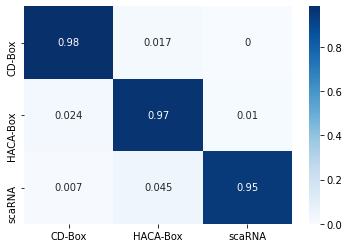

In [44]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
conf_matrix = confusion_matrix(Y_test, pred_labels_ohe_deep, normalize="true")
# Turn into a dataframe (necessary for plotting)
conf_df = pd.DataFrame(conf_matrix, index=["CD-Box", "HACA-Box", "scaRNA"], columns=["CD-Box", "HACA-Box", "scaRNA"])

# Plot the heatmap
sns.heatmap(conf_df, annot=True, cmap="Blues")

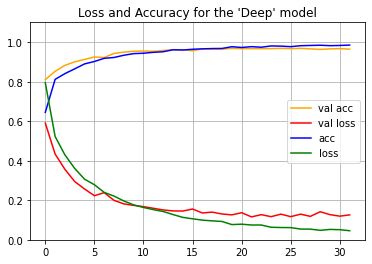

In [45]:
ax = plt.subplot()

# Plot the validation scores
ax.plot(history.history['val_accuracy'], label=f'val acc', color="orange", alpha=1)
ax.plot(history.history['val_loss'], label=f'val loss', color="red", alpha=1)

# Plot the training scores
ax.plot(history.history['accuracy'], label=f'acc', color="blue", alpha=1)
ax.plot(history.history['loss'], label=f'loss', color="green", alpha=1)


ax.set_ylim(0,1.1)
ax.grid(True)
plt.legend()
plt.title("Loss and Accuracy for the 'Deep' model")
plt.show()

Plot the saved scores from all CNN models

[(0.6, 1.0)]

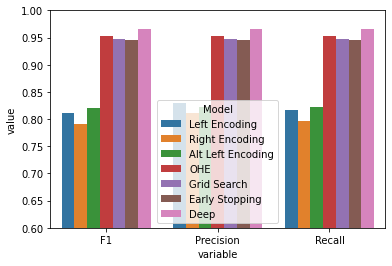

In [48]:
# Save scores in a dictionary
dictionary = {"F1": [f1_left, f1_right, f1_left_alt, f1_ohe, f1_ohe_es, f1_ohe_gs, f1_deep],
              "Precision": [prec_left, prec_right, prec_left_alt, prec_ohe, prec_ohe_es, prec_ohe_gs, prec_deep],
              "Recall": [rec_left, rec_right, rec_left_alt, rec_ohe, rec_ohe_es, rec_ohe_gs, rec_deep],
              "Model": ["Left Encoding", "Right Encoding", "Alt Left Encoding", "OHE", "Grid Search", "Early Stopping", "Deep"]}
# Turn into a dataframe
df = pd.DataFrame(dictionary)
df = pd.melt(df, id_vars=["Model"])

# Plot Barplot with scores
plot = sns.barplot(data=df, x="variable", y="value", hue="Model")
plt.legend(loc='lower right')
plot.set(ylim=(0.6, 1))

# Try to find the perfect solution for the problem

CNN creation takes a lot of intuition, experience but also some trial and error. 
Most of the times you don't need to change a lot of hyperparameter and combinations to see if the problem can be solved successfully but for optimizing hte last percentages in your model this can be consume quite some time. Many combinations of hyperparameters and architectures will only lead to marginal classification differences. 

So far, we have not talked about many additional hyperparameters including different activation functions and padding, but you may also look at the Keras documentation to see, what other options are available.

This last box will be now allowing you for the next 10-15 minutes to test your model of choice and see if you can improve the classification further.


In [47]:
def create_cnn_model_6():

    model = keras.Sequential()

    # Set the parameters to a combination you want to test
    model.add(keras.layers.Conv1D(XXX, XXX, activation='relu', padding='same', input_shape=(600, 5)))
    model.add(keras.layers.MaxPooling1D(XXX))
    model.add(keras.layers.Dropout(rate=XXX))
    
    # How about a second block of layers? 
    model.add(keras.layers.Conv1D(XXX, XXX, activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling1D(XXX))
    model.add(keras.layers.Dropout(rate=XXX))
    
    # Even more convolutions? You can also try to switch up the structure of the blocks
    # maybe try to add a second convolutional layer before the MaxPooling step
    
    # DO NOT CHANGE
    model.add(keras.layers.Flatten())
    
    # Often times, convolutional layers have a "Dense Head", i.e. multiple Dense layers before the output. Maybe this improves classification
    model.add(keras.layers.Dense(XXX, activation="relu"))
    
    # DO NOT CHANGE
    model.add(keras.layers.Dense(3, activation="softmax"))

    # Test different optimizers
    optimizer1 = keras.optimizers.Adam(learning_rate=XXX)
    optimizer2 = keras.optimizers.SGD(learning_rate=XXX)
    optimizer3 = keras.optimizers.XXX(learning_rate=XXX)
    
    model.compile(optimizer=XXX, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Now create and fit your model. Keep in mind, that [learning rate and batch size are related](https://www.baeldung.com/cs/learning-rate-batch-size), so if you change one of them you would usually want to change the other one as well.

In [ ]:
model = create_model_6()
model.fit(X_train_array_ohe, Y_train_ohe, epochs=XXX, batch_size=XXX, verbose=2, validation_split=0.15)

prediction_your_model = model.predict(X_test_array_ohe)

pred_labels_your_model = ohe.inverse_transform(prediction_your_model)
print(classification_report(Y_test, pred_labels_your_model, digits=4))

# Creating and including more information from the initial sequences 

While we could probably get better accuracy through further optimization, we also have the option to change the data input for the classification problem. In our case we can use the initial sequences of ncRNAs and predict from them the secondary structure of the sequence. As the function of snoRNAs is generally defined by their secondary structure this could gain more information. 

## See you in 3_cnn_sec_struct.ipynb
